ELECTRE: índice 0, f1=14.00, f2=1735.66
PROMETHEE: índice 5, f1=31.00, f2=1711.14


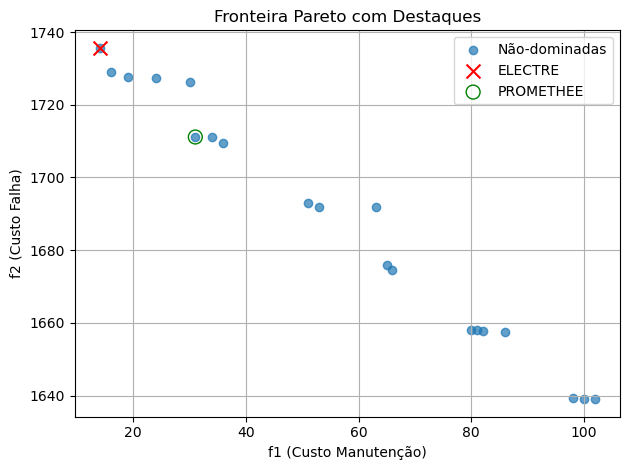

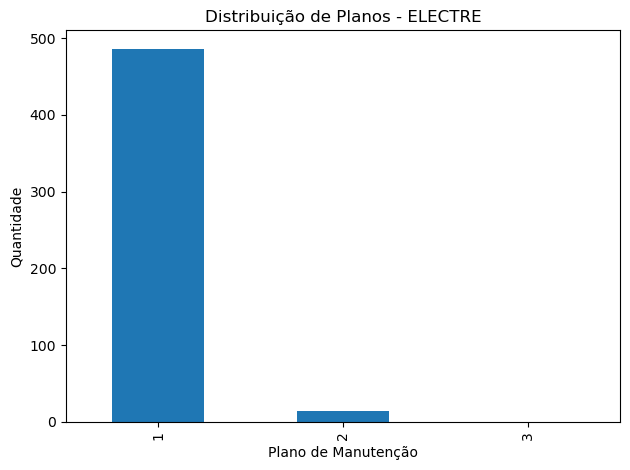

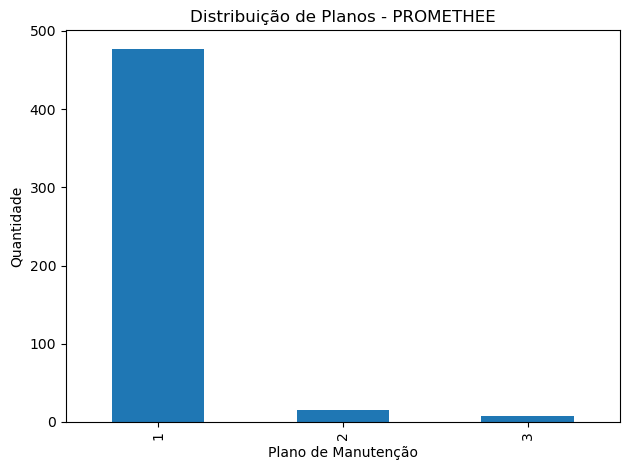

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Carregar dados originais
equip_df = pd.read_csv('arquivos_tc/EquipDB.csv', header=None, names=['ID','t0','cluster','custo_falha'])
mp_df = pd.read_csv('arquivos_tc/MPDB.csv', header=None, names=['ID','k','custo_manutencao'])
cluster_df = pd.read_csv('arquivos_tc/ClusterDB.csv', header=None, names=['ID','eta','beta'])
solucoes_df = pd.read_csv('resultados_pareto_epsilon_rest_penalidade_2025-06-23_01-34-10.csv')

# Parâmetros
delta_t = 5  # horizonte de planejamento (anos)
eps = 1e-9

# Função de distribuição acumulada de Weibull
def F(t, eta, beta):
    return 1 - np.exp(-(t/eta)**beta)

# Calcular f1 e f2 para cada solução
f1_list, f2_list = [], []
for _, sol in solucoes_df.iterrows():
    f1 = 0.0
    f2 = 0.0
    for i, plano in enumerate(sol.values):
        # Dados do equipamento i
        t0 = equip_df.loc[i, 't0']
        cluster_id = int(equip_df.loc[i, 'cluster'])
        custo_falha = equip_df.loc[i, 'custo_falha']
        # Parâmetros do plano
        k = mp_df.loc[int(plano)-1, 'k']
        custo_m = mp_df.loc[int(plano)-1, 'custo_manutencao']
        # Parâmetros do cluster
        eta = cluster_df.loc[cluster_id-1, 'eta']
        beta = cluster_df.loc[cluster_id-1, 'beta']
        # Probabilidade de falha condicionada
        F0 = F(t0, eta, beta)
        Fk = F(t0 + k*delta_t, eta, beta)
        p_fail = (Fk - F0) / (1 - F0 + eps)
        # Acumular custos
        f1 += custo_m
        f2 += p_fail * custo_falha
    f1_list.append(f1)
    f2_list.append(f2)

# Criar DataFrame de avaliação
df = pd.DataFrame({'f1': f1_list, 'f2': f2_list})

# Funções de dominância
def is_dominated(a, b):
    return all(b_i <= a_i for a_i, b_i in zip(a, b)) and any(b_i < a_i for a_i, b_i in zip(a, b))

def non_dominated_indices(values):
    nd = []
    for i, vi in enumerate(values):
        if not any(is_dominated(vi, vj) for j, vj in enumerate(values) if i != j):
            nd.append(i)
    return nd

# Selecionar não-dominadas e limitar a 20 solucoes
nds = non_dominated_indices(df[['f1','f2']].values)
df_nd = df.iloc[nds].reset_index(drop=True)
sol_nd = solucoes_df.iloc[nds].reset_index(drop=True)
if len(df_nd) > 20:
    sel = df_nd.nsmallest(20, ['f1','f2']).index
df_nd = df_nd.loc[sel].reset_index(drop=True)
sol_nd = sol_nd.loc[sel].reset_index(drop=True)

# ELECTRE I simplificado
def electre(mat, c_thr=0.6, d_thr=0.4):
    n, m = mat.shape
    C = np.zeros((n,n)); D = np.zeros((n,n))
    nm = (mat - mat.min())/(mat.max()-mat.min()+eps)
    for i in range(n):
        for j in range(n):
            if i == j: continue
            cset = [k for k in range(m) if nm.iloc[i,k] <= nm.iloc[j,k]]
            dset = [k for k in range(m) if nm.iloc[i,k] > nm.iloc[j,k]]
            C[i,j] = len(cset)/m
            if dset: D[i,j] = max(abs(nm.iloc[i,k]-nm.iloc[j,k]) for k in dset)
    outrank = (C>=c_thr)&(D<=d_thr)
    scores = outrank.sum(axis=1)
    return scores.argmax(), scores

# PROMETHEE I simplificado
def promethee(mat):
    n, m = mat.shape
    P = np.zeros((n,n))
    nm = (mat - mat.min())/(mat.max()-mat.min()+eps)
    for i in range(n):
        for j in range(n):
            if i!=j:
                diff = nm.iloc[i]-nm.iloc[j]
                P[i,j] = sum(max(0,d) for d in diff)
    phi_p = P.sum(axis=1)/(n-1)
    phi_m = P.sum(axis=0)/(n-1)
    net = phi_p - phi_m
    return net.argmax(), net

# Preparar matriz de decisão (minimização)
dec_matrix = -df_nd[['f1','f2']]

# Executar métodos
e_idx, _ = electre(dec_matrix)
p_idx, _ = promethee(dec_matrix)

# Imprimir resultados finais
for name, idx in [('ELECTRE', e_idx), ('PROMETHEE', p_idx)]:
    print(f"{name}: índice {idx}, f1={df_nd.loc[idx,'f1']:.2f}, f2={df_nd.loc[idx,'f2']:.2f}")

# Plotar fronteira Pareto (f1 vs f2)
plt.figure()
plt.scatter(df_nd['f1'], df_nd['f2'], alpha=0.7, label='Não-dominadas')
plt.scatter(df_nd['f1'].iloc[e_idx], df_nd['f2'].iloc[e_idx], c='red', marker='x', s=100, label='ELECTRE')
plt.scatter(df_nd['f1'].iloc[p_idx], df_nd['f2'].iloc[p_idx], facecolors='none', edgecolor='green', s=100, label='PROMETHEE')
plt.xlabel('f1 (Custo Manutenção)')
plt.ylabel('f2 (Custo Falha)')
plt.title('Fronteira Pareto com Destaques')
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# Plotar distribuição de planos para cada método
for name, idx in [('ELECTRE', e_idx), ('PROMETHEE', p_idx)]:
    contagem = sol_nd.iloc[idx].value_counts().sort_index()
    for plano in [1, 2, 3]:
        if plano not in contagem:
            contagem[plano] = 0
    contagem = contagem.sort_index()
    plt.figure()
    contagem.plot(kind='bar')
    plt.xlabel('Plano de Manutenção')
    plt.ylabel('Quantidade')
    plt.title(f'Distribuição de Planos - {name}')
    plt.tight_layout()
    plt.show()
